<a href="https://colab.research.google.com/github/RafauZet/From-XML-to-SHP/blob/main/SHP_file_from_XML_file_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating SHP file (data frame with geometry) using XML file


## Installing and importing necessary libraries

In [1]:
!pip install wget lxml contextily -q

In [2]:
import lxml
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import wget
import xml.etree.ElementTree as ET
import shapely
import contextily as ctx

from lxml import etree
from collections import namedtuple
from pyproj import Transformer
from tqdm import notebook, tqdm
from google.colab import files

## Downloading and preparing dataset

In [3]:
#Downloading and unpacking dataset from geoportal.gov.pl, which is the service
#of the spatial information infrastructure with access to spatial data
url_waw = 'https://opendata.geoportal.gov.pl/bdot10k/schemat2021/14/1465_GML.zip'

try:
  response = requests.get(url_waw)
  if response.status_code == 200:
    file = wget.download(url_waw)
    !unzip -n -qq '1465_GML.zip'
    print('Success. Dataset has been downloated and unpacked.')
  else:
    print('Error')
    print('Try to upload the file using google colab:')
    files.upload()
    !unzip -n -qq '1465_GML.zip'
    print('Success. Dataset has been unpacked.')
except Exception as e:
  print(f'An error occured: {e}')
  print('Try to upload the file using google colab:')
  files.upload()
  !unzip -n -qq '1465_GML.zip'
  print('Success. Dataset has been unpacked.')

Success. Dataset has been downloated and unpacked.


In [4]:
#Loading XML file
path = '/content/PL.PZGiK.330.1465/BDOT10k/PL.PZGiK.330.1465__OT_BUBD_A.xml'
tree = etree.parse(path).getroot()
#XML schema instance namespaces
tree.nsmap

{'xsi': 'http://www.w3.org/2001/XMLSchema-instance',
 'xlink': 'http://www.w3.org/1999/xlink',
 'gml': 'http://www.opengis.net/gml/3.2',
 'ot': 'urn:gugik:specyfikacje:gmlas:bazaDanychObiektowTopograficznych10k:2.0'}

In [5]:
#Making named tuple
buildings_tuple = namedtuple('Building', ('main_function', 'name', 'storeys', 'geometry'))

In [6]:
#Paths to data in XML file
path_bdw = './/ot:OT_BUBD_A'
path_function = './ot:funkcjaSzczegolowaBudynku'
path_geometry = './ot:geometria/gml:Polygon/gml:exterior/gml:LinearRing/gml:posList'
path_contignation = './ot:liczbaKondygnacji'
path_name = './ot:nazwa'

In [7]:
#Making list of namedtuples with information about buildings from XML file.
buildingsList = []

for msc in notebook.tqdm(tree.findall(path_bdw, namespaces=tree.nsmap)):
  function = msc.find(path_function, namespaces=tree.nsmap)
  if function is not None:
      function = msc.find(path_function, namespaces=tree.nsmap).text
  else:
    pass
  name = msc.find(path_name, namespaces=tree.nsmap)
  if name is not None:
    name = msc.find(path_name, namespaces=tree.nsmap).text
  else:
    pass
  storeys = msc.find(path_contignation, namespaces=tree.nsmap)
  if storeys is not None:
    storeys = msc.find(path_contignation, namespaces=tree.nsmap).text
  else:
    pass
  geometry = msc.find(path_geometry, namespaces=tree.nsmap)
  if geometry is not None:
    geometry = msc.find(path_geometry, namespaces=tree.nsmap).text
  else:
    pass
  buildingsList.append(buildings_tuple(function, name, storeys, geometry))

  0%|          | 0/155307 [00:00<?, ?it/s]

## Processing dataset into a shape file (.SHP)

In [8]:
#Creating data frame from list (buildingList)
df = pd.DataFrame.from_records(buildingsList, columns=buildings_tuple._fields)
print(f'''Shape of DataFrame:
-number of rows: {df.shape[0]}
-number of columns: {df.shape[1]}
      ''')
df.head(10)

Shape of DataFrame: 
-number of rows: 155307
-number of columns: 4
      


,main_function,name,storeys,geometry
0,warsztat remontowo-naprawczy,None,2,632292.67 480691.09 632299.08 480688.7 632298....
1,hipermarket lub supermarket,None,4,632048.79 480057.24 632091.88 480125.25 632122...
2,budynek jednorodzinny,None,2,629661.32 483097.23 629665.69 483105.23 629660...
3,budynek jednorodzinny,None,1,641002.38 493055.47 641007.66 493064.54 640993...
4,budynek jednorodzinny,None,1,641465.82 493056.72 641463.92 493052.31 641473...
5,budynek jednorodzinny,None,2,640896.65 493063.85 640902.05 493051.62 640905...
6,budynek jednorodzinny,None,1,641511.27 493051.11 641517.71 493064.64 641508...
7,budynek jednorodzinny,None,1,650129.51 488353.93 650136.07 488353.09 650135...
8,budynek jednorodzinny,None,2,640613.94 493676.17 640613.76 493671.98 640614...
9,inny urząd administracji publicznej,None,2,638022.69 486496.57 638013.25 486493.16 638012...


In [9]:
#Processing data from 'geometry' column to geometry using Shapely library
for index, row in notebook.tqdm(df.iterrows(), total=df.shape[0]):
  geometryStringToList = df['geometry'][index].split()
  indices = (0,1)
  coordsList = []
  geometryCellIterations = int(len(geometryStringToList)/2)
  for coordinate in range(geometryCellIterations):
    indices = (coordinate, coordinate+1)
    result_list = [geometryStringToList[index] for index in indices]
    geometryStringToList.pop(0)
    coordsList.append(result_list)
    tuple(coordsList)
  df['geometry'][index] = shapely.Polygon(coordsList)

  0%|          | 0/155307 [00:00<?, ?it/s]

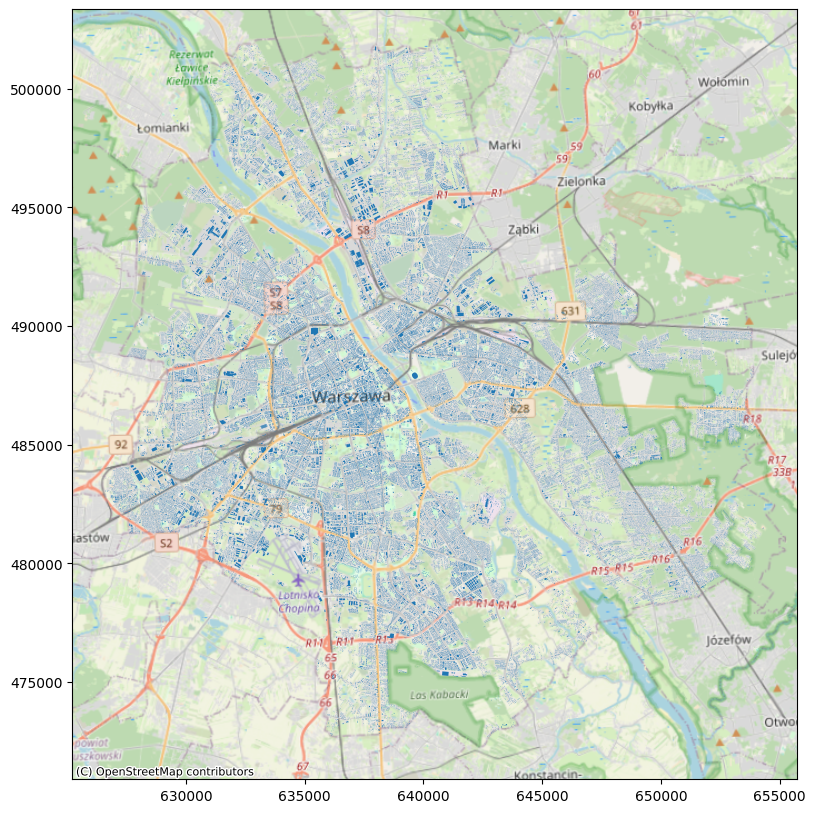

,main_function,name,storeys,geometry
0,warsztat remontowo-naprawczy,None,2,"POLYGON ((632292.67 480691.09, 632299.08 48068..."
1,hipermarket lub supermarket,None,4,"POLYGON ((632048.79 480057.24, 632091.88 48012..."
2,budynek jednorodzinny,None,2,"POLYGON ((629661.32 483097.23, 629665.69 48310..."
3,budynek jednorodzinny,None,1,"POLYGON ((641002.38 493055.47, 641007.66 49306..."
4,budynek jednorodzinny,None,1,"POLYGON ((641465.82 493056.72, 641463.92 49305..."
5,budynek jednorodzinny,None,2,"POLYGON ((640896.65 493063.85, 640902.05 49305..."
6,budynek jednorodzinny,None,1,"POLYGON ((641511.27 493051.11, 641517.71 49306..."
7,budynek jednorodzinny,None,1,"POLYGON ((650129.51 488353.93, 650136.07 48835..."
8,budynek jednorodzinny,None,2,"POLYGON ((640613.94 493676.17, 640613.76 49367..."
9,inny urząd administracji publicznej,None,2,"POLYGON ((638022.69 486496.57, 638013.25 48649..."


In [10]:
#Coordinate system uses in Poland
crs = 'epsg:2180'

#Ploting data with basemap form Open Street Map
gdf = gpd.GeoDataFrame(data=df, geometry=df['geometry'], crs=crs)
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=crs, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

print('\n')

#Showing GeoDataFrame
gdf.head(10)

In [11]:
#Making new folder
!mkdir 'SHP_file_from_XML_file'

#Saving GeoDataFrame to ShapeFile (.SHP)
gdf.to_file('/content/SHP_file_from_XML_file/SHP_file_from_XML_file.shp', driver='ESRI Shapefile')

#Compress .SHP file to .ZIP
!zip -r '/content/SHP_file_from_XML_file.zip' '/content/SHP_file_from_XML_file'

#Downloading .ZIP file
files.download('/content/SHP_file_from_XML_file.zip')



mkdir: cannot create directory ‘SHP_file_from_XML_file’: File exists


<ipython-input-11-d730ce9b3324>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('/content/SHP_file_from_XML_file/SHP_file_from_XML_file.shp', driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'main_function' to 'main_funct'
  ogr_write(


updating: content/SHP_file_from_XML_file/ (stored 0%)
updating: content/SHP_file_from_XML_file/SHP_file_from_XML_file.shp (deflated 61%)
updating: content/SHP_file_from_XML_file/SHP_file_from_XML_file.cpg (stored 0%)
updating: content/SHP_file_from_XML_file/SHP_file_from_XML_file.shx (deflated 53%)
updating: content/SHP_file_from_XML_file/SHP_file_from_XML_file.dbf (deflated 99%)
updating: content/SHP_file_from_XML_file/SHP_file_from_XML_file.prj (deflated 36%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>